In [8]:
from datetime import datetime, timedelta
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from xgboost import XGBRegressor
import yfinance as yf

In [9]:
# ---------------------------------
# 1. Request and accept user input
# ---------------------------------
# ticker = input("Enter stock ticker (e.g., AAPL): ").upper()
# lookback_years = int(input("Enter lookback period in years (e.g., 3): "))
# forecast_days = int(input("Enter number of future business days to predict (e.g., 60): "))
ticker = "AAPL"  # Example ticker
lookback_years = 3  # Example lookback period
forecast_days = 60  # Example forecast days

In [10]:
# -------------------------------
# 2. Download and Prepare Data
# -------------------------------
end_date = datetime(2024, 12, 31)
start_date = end_date - timedelta(days=lookback_years * 365)
# start_date = "2021-01-01"
# end_date = "2024-12-31"
df = yf.download(ticker, start=start_date, end=end_date)
df.columns = df.columns.get_level_values(0)
df = df[["Close"]].copy()

/var/folders/7b/5whxx2ds7sv4t457xjktwchh0000gn/T/ipykernel_1434/2285389441.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


In [11]:

# -------------------------------
# 2. Feature Engineering
# -------------------------------
def add_features(data):
    df = data.copy()
    df["Return_1"] = df["Close"].pct_change()
    for window in [2, 5, 10, 30, 60, 90, 180, 250]:
        df[f"MA_{window}"] = df["Close"].rolling(window).mean()
        df[f"STD_{window}"] = df["Close"].rolling(window).std()
    df = df.dropna()
    return df

features_df = add_features(df)

In [12]:

# -------------------------------
# 3. Train-Test Split
# -------------------------------
train = features_df.loc[:'2024-12-31']
X_train = train.drop(columns=["Close"])
y_train = train["Close"]
used_features = X_train.columns.tolist()

In [13]:



# -------------------------------
# 4. Train Multiple Models
# -------------------------------
ridge = Ridge(alpha=1.0)
rf = RandomForestRegressor(n_estimators=100, random_state=42)
xgb = XGBRegressor(n_estimators=100, random_state=42)

ridge.fit(X_train, y_train)
rf.fit(X_train, y_train)
xgb.fit(X_train, y_train)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [14]:


# -------------------------------
# 5. Forecast 2025 Daily Prices
# -------------------------------
forecast_start = end_date + timedelta(days=1)
future_dates = pd.date_range(start=forecast_start, periods=forecast_days, freq='B')
# forecast_start = datetime(2025, 1, 1)
# forecast_end = datetime(2025, 8, 1)
future_dates = pd.date_range(start=forecast_start, periods=forecast_days, freq='B')

synthetic = df.copy()
predictions = []

for date in future_dates:
    latest = add_features(synthetic)
    try:
        X_pred = latest[used_features].iloc[[-1]]
    except IndexError:
        print(f"Skipping {date}: not enough history.")
        continue
    if X_pred.isnull().any().any():
        print(f"Skipping {date}: NaNs in input.")
        continue

    # Base predictions
    pred_ridge = ridge.predict(X_pred)[0]
    pred_rf = rf.predict(X_pred)[0]
    pred_xgb = xgb.predict(X_pred)[0]
    base_pred = np.mean([pred_ridge, pred_rf, pred_xgb])

    # Inject general upward trend (0.1% daily growth compounded)
    trend_factor = 1.001
    trended_pred = base_pred * trend_factor

    # Add volatility (recent 30-day rolling std dev)
    recent_std = latest["STD_30"].iloc[-1] if "STD_30" in latest.columns else 5
    noise = np.random.normal(loc=0, scale=recent_std)
    final_pred = trended_pred + noise

    # Ensure the price doesn't drop below a threshold (optional)
    final_pred = max(final_pred, 0.01)

    synthetic = pd.concat([synthetic, pd.DataFrame({"Close": [final_pred]}, index=[date])])
    predictions.append((date, final_pred))




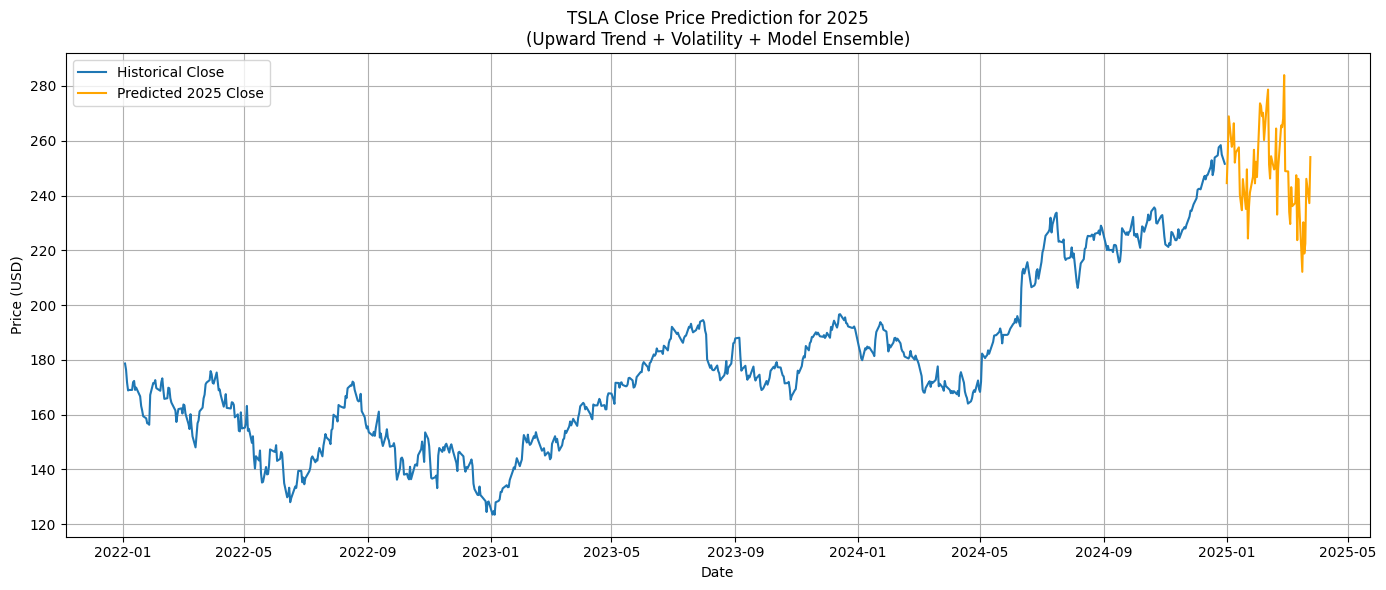

In [15]:
# -------------------------------
# 6. Plot Results
# -------------------------------
predicted_df = pd.DataFrame(predictions, columns=["Date", "Predicted_Close"]).set_index("Date")

plt.figure(figsize=(14, 6))
plt.plot(df["Close"], label="Historical Close")
plt.plot(predicted_df["Predicted_Close"], label="Predicted 2025 Close", color="orange")
plt.title("TSLA Close Price Prediction for 2025\n(Upward Trend + Volatility + Model Ensemble)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [16]:
data = yf.download("TSLA", start="2000-01-01", end = "2024-12-31", interval="1d")
data.columns = data.columns.get_level_values(0)  # Drops the ticker level
data.head()

/var/folders/7b/5whxx2ds7sv4t457xjktwchh0000gn/T/ipykernel_1434/1872405879.py:1: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("TSLA", start="2000-01-01", end = "2024-12-31", interval="1d")
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


In [17]:
# data["Target Close"]  = data["Close"].shift(-1)
# data["Target Open"] = data["Open"].shift(-1)
data = data.dropna()

In [18]:
# data["Target Close Binary"] = (data["Target Close"] > data["Close"]).astype(int)
# data["Target Open Binary"] = (data["Target Open"] > data["Open"]).astype(int)

In [19]:
print(data.head())

Price          Close      High       Low      Open     Volume
Date                                                         
2010-06-29  1.592667  1.666667  1.169333  1.266667  281494500
2010-06-30  1.588667  2.028000  1.553333  1.719333  257806500
2010-07-01  1.464000  1.728000  1.351333  1.666667  123282000
2010-07-02  1.280000  1.540000  1.247333  1.533333   77097000
2010-07-06  1.074000  1.333333  1.055333  1.333333  103003500


In [20]:
# Calculate rolling averages
rolling_windows = [2, 5, 10, 30, 60, 90, 180, 250]

# for window in rolling_windows:
#     data[f"Rolling_{window}"] = data["Close"].shift(1).rolling(window=window).mean()


In [21]:
# Calculate ratio of closing price to rolling averages
# for window in rolling_windows:
#     data[f"Close_vs_Rolling_{window}"] = data["Close"] / data[f"Rolling_{window}"]


In [22]:
data = data.dropna()  # Drop rows with NaN values after rolling calculations
data.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


In [23]:
train = data.loc["2000-01-01":"2024-12-31"].copy()
train.dropna(inplace=True)
forecast_target = pd.date_range(start="2025-01-01", end="2025-08-01", freq="B")  # Business days
feature_cols = [col for col in train.columns if "Target" not in col]
y = train["Close"]
X = train[feature_cols]
ridge = Ridge()
ridge.fit(X, y)

,alpha,1.0
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'auto'
,positive,False
,random_state,None


In [24]:
# Initialize with the training data
synthetic = train.copy()
predictions = []
synthetic.head()

Price,Close,High,Low,Open,Volume
Date,,,,,
2010-06-29,1.592667,1.666667,1.169333,1.266667,281494500
2010-06-30,1.588667,2.028000,1.553333,1.719333,257806500
2010-07-01,1.464000,1.728000,1.351333,1.666667,123282000
2010-07-02,1.280000,1.540000,1.247333,1.533333,77097000
2010-07-06,1.074000,1.333333,1.055333,1.333333,103003500


In [25]:


for date in forecast_target:
    # Generate features based on latest data
    latest = synthetic.copy()
    
    # Get the most recent row (i.e., yesterday)
    X_pred = latest[feature_cols].iloc[[-1]]

    # Predict
    pred_close = ridge.predict(X_pred)[0]
    
    # Create synthetic row
    # new_row = {
    #     "Close": pred_close,
    # }
    
    # # Append predicted row to synthetic dataset
    # new_df = pd.DataFrame([new_row], index=[date])
    # synthetic = pd.concat([synthetic, new_df])
    
    # predictions.append((date, pred_close))
predictions.head()

AttributeError: 'list' object has no attribute 'head'

In [ ]:
X.dtypes

Price
Close                   float64
High                    float64
Low                     float64
Open                    float64
Volume                    int64
Rolling_2               float64
Rolling_5               float64
Rolling_10              float64
Rolling_30              float64
Rolling_60              float64
Rolling_90              float64
Rolling_180             float64
Rolling_250             float64
Close_vs_Rolling_2      float64
Close_vs_Rolling_5      float64
Close_vs_Rolling_10     float64
Close_vs_Rolling_30     float64
Close_vs_Rolling_60     float64
Close_vs_Rolling_90     float64
Close_vs_Rolling_180    float64
Close_vs_Rolling_250    float64
dtype: object

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, shuffle=False  # Don't shuffle time series!
)

In [ ]:
assert X_train.index.max() < X_test.index.min()


In [ ]:
print(y_test.index)

DatetimeIndex(['2024-03-13', '2024-03-14', '2024-03-15', '2024-03-18',
               '2024-03-19', '2024-03-20', '2024-03-21', '2024-03-22',
               '2024-03-25', '2024-03-26',
               ...
               '2025-07-16', '2025-07-17', '2025-07-18', '2025-07-21',
               '2025-07-22', '2025-07-23', '2025-07-24', '2025-07-25',
               '2025-07-28', '2025-07-29'],
              dtype='datetime64[ns]', name='Date', length=345, freq=None)


In [ ]:
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(alpha=1.0),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

results = {}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {"MSE": mse, "R2": r2}
    print(f"{name} - MSE: {mse:.4f}, R2: {r2:.4f}")

Linear Regression - MSE: 146.1683, R2: 0.9759
Ridge Regression - MSE: 144.4222, R2: 0.9762


/Users/sambudlong/sam_github/stock-predictions/stock-predictor-env/lib/python3.11/site-packages/scipy/_lib/_util.py:1233: LinAlgWarning: Ill-conditioned matrix (rcond=6.71986e-19): result may not be accurate.
  return f(*arrays, *other_args, **kwargs)


Random Forest - MSE: 354.4916, R2: 0.9416
XGBoost - MSE: 894.6464, R2: 0.8527


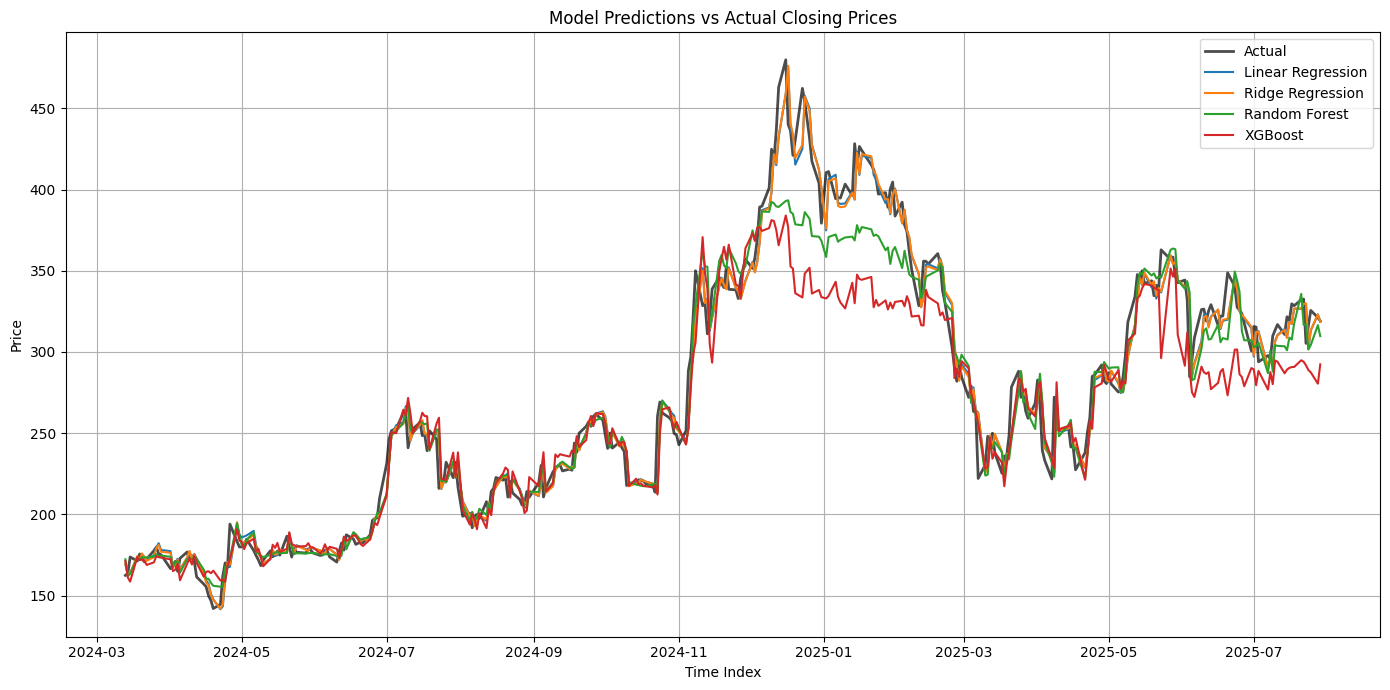

In [ ]:
plt.figure(figsize=(14, 7))

# Plot actual values
plt.plot(y_test.index, y_test.values, label="Actual", linewidth=2, color='black', alpha=0.7)

# Plot predictions for each model
for name, model in models.items():
    preds = model.predict(X_test)
    plt.plot(y_test.index, preds, label=name)

plt.title("Model Predictions vs Actual Closing Prices")
plt.xlabel("Time Index")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()